<a href="https://colab.research.google.com/github/constructor-s/aps1080_winter_2021/blob/main/E4/E4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Exercise IV: Function Approximation
> ===================================
> 
> Submit Assignment
> 
> *   Due Tuesday by 11:59pm
> *   Points 10
> *   Submitting a file upload
> *   File Types pdf
> 
> You will use function approximation to device controllers for the mountain car and/or cart pole problems in Assignment IV.
> 
> Rather than code a function approximation class (straightforward but outside of the scope of our course), you'll use a library, TensorFlow, for this.
> 
> There are two front ends for TensorFlow that make it easier to construct, debug, etc., neural networks (general nonlinear function approximation structures): Keras (keras.io) and TfLearn (tflearn.org).
> 
> Consult the documentation for these two (either, your choice) and learn how to:
> 
> *   Construct a neural network with several layers
> *   Obtain the gradient of the neural network with respect to its parameters
> *   Train the neural network by stochastic gradient descent using a loop that you construct and in which you update the weights as per the gradient and the error (you will use this in A-IV)
> 
> Submit, via pdf, the results of your investigation. Graded for completion; this is an opportunity for you to ask questions in case you are stuck.
> 
> Consult Files/stochastic\_gradient\_descent\_example.py for one example to help you get started.
> 
> 1617163199 03/30/2021 11:59pm

# Set up dependencies, functions

In [1]:
#%% Set up rendering

if False:
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    display = Display(visible=False, size=(400, 300))
    display.start()

In [2]:
#%% Imports

import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import *
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import datetime
import time


The function below generates episodes of experience - see doc string for details

In [38]:
#%% Set up the environment
def run_env(policy_fun, 
            env, max_iter=1000, 
            debug=False, plot=False):
    """
    Simulate episodes of the environment

    Parameters
    ------------------
    policy_fun : function
        A function that maps observation, and current time step index 
        to valid action
    
    debug : bool
        print the last two states

    plot : bool
        plot visualization during select steps
        a (virtual) screen must be available for gym render

    Yields
    ------------------
    O_t, A_t, R_t+1, O_t+1, A_t+1, done
        SARSA pairs. O is the observation.
    """
    if plot:
        fig, ax = plt.subplots(2, 5, figsize=(11, 8.5))

    obs = env.reset() 
    a = policy_fun(obs, 0)
    for i in range(max_iter):
        next_obs, r, done, info = env.step(a) 
        next_a = policy_fun(next_obs, i+1)
        yield obs, a, r, next_obs, next_a, done

        if plot and i%20 == 19:
            # Visualize some states
            ax.ravel()[i // 20].imshow(env.render(mode='rgb_array'))
            ax.ravel()[i // 20].set_title(
                f"Step {i}, obs =\n{np.array2string(obs, precision=1)}")
        if debug and done:
            print(f"Observation at i = {i}: {obs}")

        obs, a = next_obs, next_a

        if done:

            if debug:
                print(f"Observation at terminal: {obs}")
            if plot:
                ax.ravel()[-1].imshow(env.render(mode='rgb_array'))
                ax.ravel()[-1].set_title(
                    f"Step {i}, obs =\n{np.array2string(obs, precision=1)}")
                
            break
    env.close()

print("Generating a random episode:")
env = gym.make('CartPole-v0') # gym.make('CartPole-v0')
pd.DataFrame(run_env(lambda *_, **__: env.action_space.sample(),
                     plot='display' in globals(), 
                     env=env),
             columns=["O_t", "A_t", "R_t+1", "O_t+1", "A_t+1", "done"])

Generating a random episode:


,O_t,A_t,R_t+1,O_t+1,A_t+1,done
0,"[-0.026986313288588692, 0.03475086569471908, 0...",1,1.0,"[-0.02629129597469431, 0.22960249612953862, 0....",0,False
1,"[-0.02629129597469431, 0.22960249612953862, 0....",0,1.0,"[-0.02169924605210354, 0.03421445878701693, 0....",0,False
2,"[-0.02169924605210354, 0.03421445878701693, 0....",0,1.0,"[-0.0210149568763632, -0.1611021566496206, 0.0...",1,False
3,"[-0.0210149568763632, -0.1611021566496206, 0.0...",1,1.0,"[-0.02423700000935561, 0.033810508069687495, 0...",0,False
4,"[-0.02423700000935561, 0.033810508069687495, 0...",0,1.0,"[-0.023560789847961863, -0.16160846049819008, ...",0,False
5,"[-0.023560789847961863, -0.16160846049819008, ...",0,1.0,"[-0.026792959057925662, -0.35703737309313704, ...",0,False
6,"[-0.026792959057925662, -0.35703737309313704, ...",0,1.0,"[-0.0339337065197884, -0.5525508277238524, 0.0...",0,False
7,"[-0.0339337065197884, -0.5525508277238524, 0.0...",0,1.0,"[-0.04498472307426545, -0.7482107532145794, 0....",0,False
8,"[-0.04498472307426545, -0.7482107532145794, 0....",0,1.0,"[-0.05994893813855704, -0.9440564859014975, 0....",0,False
9,"[-0.05994893813855704, -0.9440564859014975, 0....",0,1.0,"[-0.078830067856587, -1.1400934770691102, 0.11...",0,False


# Training

## Set up Multi-Layer Perceptron

In [4]:
#%% Episodic semi-gradient Sarsa for estimating q
# Page 244
# Set up a differentiable action-value function parameterization
class Net(nn.Module):
    def __init__(self, hidden_size=(256, 128)):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], env.action_space.n)

    def forward(self, x):
        # Normalize x to approximately -1 to +1
        if env.spec.id == 'CartPole-v0':
            x = (x - (-2.3, -1.0, -0.20, -1.0)) / 2.0 / (+2.3, +1.0, +0.20, +1.0)
        else:
            x = (x - env.observation_space.low) / (
                env.observation_space.high - env.observation_space.low)
        x = torch.tensor(x, dtype=torch.float).to(self.device)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Assume output is approximately -1 to +1, 
        # Multiply into the scale of the return in the model
        x = x * 100
        
        return x
    
    @property
    def device(self):
        return next(self.parameters()).device


## n-step training algorithm as described on textbook

[200, 200, 200]
2021-03-28 01:30:38.444007


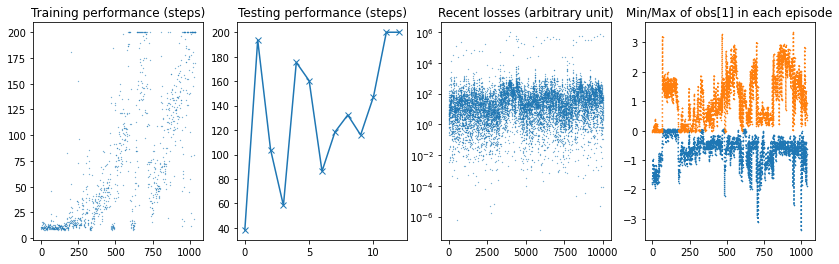

Good test performance - stop training
Training finished in 0:02:13.076214


In [39]:
# Initialize parameters
alpha = 1.0e-4
eps = 0.2
gamma = 0.9999
# weights w handled by library
net = Net(hidden_size=(512, 32))
optimizer = optim.Adam(net.parameters(), lr=alpha) # optim.SGD(net.parameters(), lr=alpha) # optim.SGD(net.parameters(), lr=alpha) # optim.Adam(net.parameters(), lr=alpha) # optim.SGD(net.parameters(), lr=alpha)
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
# TD n step
n = 5
rng = np.random.RandomState(0)

# Monitor training history
history_steps = []
history_steps_testing = []
history_loss = []
history_states = []
tic = datetime.datetime.now()
last_plot = time.time()
##

def policy_fun(obs, *args, **kwargs):
    """
    An eps greedy policy
    """
    if rng.random() < eps:
        # eps
        return env.action_space.sample()
    else:
        # Greedy
        with torch.no_grad():
            q_vals = net(obs)
        assert q_vals.isfinite().all(), q_vals
        a = int(q_vals.argmax())
        # if np.abs(q_vals[0] - q_vals[1]) < 1e-9:
        #     assert False, str(q_vals)
        return a

# Loop for each episode
for episode_i in range(10000):
    # Record steps from the episode yielded by run_env
    episode = []

    # import time
    # tic = time.perf_counter()
    for t, (s, a, r, s_, a_, done) in enumerate(run_env(policy_fun, env=env)):
        if env.spec.id == 'MountainCar-v0':
            r = r + (s_[1]*100) ** 2
        episode.append((s, a, r, s_, a_, done))
        
        tau = t - n + 1
        if tau >= 0:
            S, A, R, S_, R_, DONE = 0, 1, 2, 3, 4, 5
            
            episode_section = episode[tau:tau+n]
            G = gamma ** np.arange(len(episode_section)) @ [
                i[R] for i in episode_section
            ]
            with torch.no_grad():
                G += (1-episode_section[-1][DONE]) * (gamma ** n) * net(s_)[a_]

            optimizer.zero_grad()   # zero the gradient buffers
            q_pred = net(s)[a]
            assert q_pred.isfinite(), q_pred
            loss = criterion(q_pred, G)
            assert loss.isfinite(), loss
            loss.backward()
            optimizer.step()    # Does the update

            # Monitor training history
            history_loss.append(loss)
    history_steps.append(t+1)
    episode_states = np.array([i[S] for i in episode])
    history_states.append((episode_states[:,1].min(), episode_states[:,1].max()))
    
    if time.time() - last_plot > 10:
        last_plot = time.time()
        clear_output(wait=True)

        # Get testing performance of greedy policy
        test_performance = []
        def policy(o, *_, **__):
            with torch.no_grad():
                return int(net(o).argmax())
        for i in range(3):
            episode = list(run_env(policy, env=env))
            test_performance.append(len(episode))
        print(test_performance)
        test_performance = np.array(test_performance)
        print(datetime.datetime.now())
        history_steps_testing.append(test_performance.mean())

        # Make plots
        fig, ax = plt.subplots(1, 4, figsize=(14, 4))
        ax[0].plot(history_steps, '.', markersize=0.5)
        ax[0].set_title("Training performance (steps)")
        ax[1].plot(history_steps_testing, '-x')
        ax[1].set_title("Testing performance (steps)")
        ax[2].semilogy(history_loss[-10000:], '.', markersize=0.5)
        ax[2].set_title("Recent losses (arbitrary unit)")
        ax[3].plot(history_states, ':x', markersize=1.0)
        ax[3].set_title("Min/Max of obs[1] in each episode")
        fig.show()
        plt.show()

        # Early stopping
        if (((test_performance >= 200).all() and env.spec.id == 'CartPole-v0') or 
           ((test_performance < 200).all() and env.spec.id == 'MountainCar-v0')):
            test_performance = []
            for i in range(20):
                episode = list(run_env(policy, env=env))
                test_performance.append(len(episode))
            test_performance = np.array(test_performance)
            if (((test_performance >= 200).all() and env.spec.id == 'CartPole-v0') or 
                ((test_performance < 200).all() and env.spec.id == 'MountainCar-v0')):
                print("Good test performance - stop training")
                print("Training finished in", datetime.datetime.now() - tic)
                break
    ##



## Test the training result

Testing performance
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


Text(0.5, 0, 'Number of steps')

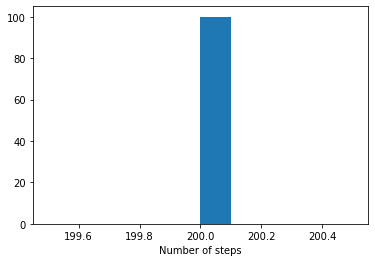

In [40]:
print("Testing performance")
test_performance = []
def policy(o, *_, **__):
    with torch.no_grad():
        return int(net(o).argmax())
for i in range(100):
    episode = list(run_env(policy, env=env))
    test_performance.append(len(episode))
print(test_performance)
plt.hist(test_performance)
plt.xlabel("Number of steps")